# Study of DNN performance for supervised learning tasks

Assignment for Laboratory of computational physics mod. B course

Group 2205 - Giovanni Cataldi, Fabio Menegazzo, Marco Rigobello, Davide Zanchetta

NOTE: this notebook serves as a demonstration of our analysis. The actual data presented in the report were produced with different codes, available at https://github.com/rgbmrc/ml-assign, which allowed us to launch in an automatized way many simulations on CloudVeneto. The operations performed here are identical to those of the actual simulations.

We start importing all the needed Python libraries to perform the Neural Network (NN) training (Tensorflow and Keras) and graphical analysis. 

In [1]:
from collections import defaultdict
from itertools import product

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf

Then, we define the main functions needed to (A) generate the input data set with the corresponding labels, (B) define, build up and train the chosen Neural Network, and (C) implementing the colormap for the grid-search. 

For more detail, see the documentation of each function.

A variable 'samples' sets the number of trials of the NN training we want to perform. 

In [2]:
samples = 1


def generate(
    N, train_frac=1.0, rescale=1.0, offset=0.0, augment_frac=0.0, augment_std=0.0
):
    """
    This function generates the input data-set of N 2-dimensional points (x1,x2) in a square box and assoaciate them to a label classifying points inside/outside a triangle.
    It defines the fraction of data devoted to the training of the network and eventually the augemtations of such data with noise normally distributed.
    Args:
        N (int):
            Number of generated points
        train_frac (float, optional):
            Fraction of input data devoted to the network training. Defaults to 1.0.
        rescale (float, optional):
            Scaling factor applied to input data (x1,x2). Defaults to 1..
        offset (float, optional):
            Offset applied to input data (x1,x2) after rescaling. Defaults to 0..
        augment_frac (float, optional):
            Fraction of training data distorted with Gaussian noise without changing labels. Defaults to 0.0.
        augment_std (float, optional):
            std deviation of the Gaussian noise used for augmentation. Defaults to 0.0.
    Returns:
        (ndarray, ndarray) :
            2D input data points (x1,x2) and the associated true 1D labels (y)

    """
    x = np.random.random((N, 2)) * 100 - 50
    y = (x[..., 0] > -20) & (x[..., 1] > -40) & ((x[..., 0] + x[..., 1]) < 40)

    x = (x - offset) / rescale

    N_train = int(N * train_frac)
    N_augment = int(N_train * augment_frac)
    x_train = np.pad(x[:N_train], ((0, N_augment), (0, 0)), mode="wrap")
    y_train = np.pad(y[:N_train], ((0, N_augment)), mode="wrap")
    x_train[:N_augment] += np.random.normal(0.0, augment_std, size=(N_augment, 2))
    valid = [a[N_train:] for a in (x, y)]
    return (x_train, y_train), valid


def train(params):
    """
    This function trains multiple times a Deep Neural Network with a chosen setup given by the parameters in 'params' and save the results of each trial into a dictionary.

    Args:
        params (dictionary of dictionaries): 
            It contains all the "parameters" to build a single DNN configuration.


    Returns:
        dictionary : 
            Results (loss function & validation accuracy) at each epoch of the DNN training, for all the investigated configurations.
    """
    samples = params.setdefault("samples", 1)
    results = defaultdict(list)

    for _ in range(samples):
        # input
        train, valid = generate(**params["input"])

        # model
        mod = tf.keras.models.Sequential(**params["model"])

        # compile
        mod.compile(**params["compile"])

        # fit
        fit = mod.fit(*train, validation_data=valid, **params["fit"])
        for k, v in fit.history.items():
            results[k].append(v)

    return results



def gridplot(vals, data):
    """
    Plot accuracy gridsearch.
    Before plotting averages over realizations.

    Args:
        vals (dictionary of 2 lists): it contains the values of the x and y axis of the gridsearch
        data (ndarray): 2d array containing the validation accuracy predicted from the DNN

    Returns:
        the colormap describing the grid search of the DNN accuracy in terms two parameters
    """
    fig, ax = plt.subplots()
    data = np.asarray(data)[..., -1].mean(-1)
    data = data.reshape([len(v) for v in vals.values()])
    sm = ax.imshow(data, origin="lower", cmap="magma")
    for axis, (p, vs) in zip((ax.yaxis, ax.xaxis), vals.items()):
        axis.set_major_locator(mpl.ticker.FixedLocator(np.arange(len(vs))))
        axis.set_major_formatter(mpl.ticker.FixedFormatter(vs))
        axis.set_label_text(p)
    cbar = fig.colorbar(sm)
    cbar.set_label("accuracy")
    return fig, ax


## Simulations

1A) Input Size vs Training fraction

We consider different sizes $N$ of the input data set with different fractions $\chi$ devoted to the training. 
Namely:
\begin{align*}
    N&\in\left\{1000,2000,4000,8000,16000\right\}\\
    \chi&\in\left\{0.6,0.7,0.8,0.9\right\}\\
\end{align*}

2022-03-19 21:49:10.926574: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


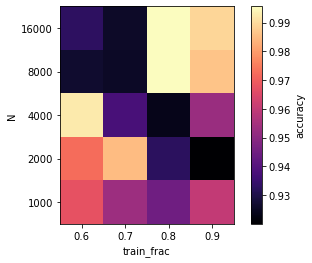

In [3]:
# Dictionary of varying parameters
vals = {
    "N": 1000 * 2 ** np.arange(5),
    "train_frac": [0.6, 0.7, 0.8, 0.9],
}

# Dictionary of DNN configuration setups
params = [
    {
        "samples": samples,
        "input": {
            "N": N,
            "rescale": 50,
            "offset": 0,
            "train_frac": train_frac,
        },
        "model": {
            "name": "model",
            "layers": [
                tf.keras.layers.Dense(2, activation="relu"),
                tf.keras.layers.Dense(20, activation="relu"),
                tf.keras.layers.Dense(20, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ],
        },
        "compile": {
            "loss": "binary_crossentropy",
            "optimizer": "adam",
            "metrics": ["accuracy"],
            "steps_per_execution": 4,
        },
        "fit": {"epochs": 500, "batch_size": 50, "verbose": 0},
    }
    for N, train_frac in product(*vals.values())
]
fig, ax = gridplot(vals, [train(p)["val_accuracy"] for p in params])

1B) Training fraction vs Augmentation Fraction

For a fixed value of $N=4000$, we consider different training fractions $\chi$ to which we apply augmentation with different percentages $\eta$. Namely:
\begin{align*}
    \chi&\in\left\{0.6,0.7,0.8,0.9\right\}\\
    \eta&\in\left\{0.0,0.\overline{3},0.\overline{6}\right\}
\end{align*}

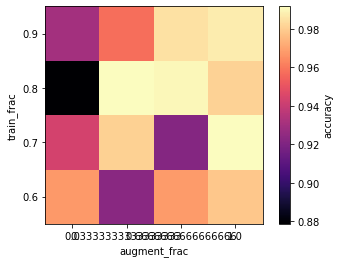

In [6]:
# Dictionary of varying parameters
vals = {
    "train_frac": np.arange(6, 10) / 10,
    "augment_frac": [0.0,0.33,0.67,1.]
}

# Dictionary of DNN configuration setups
params = [
    {
        "samples": samples,
        "input": {
            "N": 4000,
            "rescale": 50,
            "offset": 0,
            "train_frac": train_frac,
            "augment_frac": augment_frac,
            "augment_std": 0.05773502691896,
        },
        "model": {
            "name": "model",
            "layers": [
                tf.keras.layers.Dense(2, activation="relu"),
                tf.keras.layers.Dense(20, activation="relu"),
                tf.keras.layers.Dense(20, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ],
        },
        "compile": {
            "loss": "binary_crossentropy",
            "optimizer": "adam",
            "metrics": ["accuracy"],
            "steps_per_execution": 4,
        },
        "fit": {"epochs": 500, "batch_size": 50, "verbose": 0},
    }
    for train_frac, augment_frac in product(*vals.values())
]

fig, ax = gridplot(vals, [train(p)["val_accuracy"] for p in params])

2A) Activation functions vs Optimizer Algorithm

For a fixed value of $N=8000$ with $\chi=0.8$ of training, we consider different neural activation functions $\sigma$ and different optimizer algorithms (SGD, ADAM, ADAmax, RMSprop) to be adopted in the backpropagation. Among the activation functions, we select 
\begin{align*}
    \text{sigmoid}(z)&=\frac{1}{1+e^{-z}} &
    \tanh(z)&=\frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}& 
    \text{softsign}&=\frac{z}{1+|z|}
\end{align*}
\begin{align*}
    \text{ReLU}&=\text{max}(0,z)&
    \text{ELU}&=z\theta(z)+k(e^{z}-1)\theta(-z)
\end{align*}

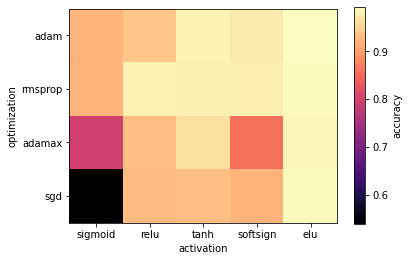

In [7]:
# region [2A]: ACTIVATION FUNCTIONS VS OPTIMIZER ALGORITHMS

# Dictionary of varying parameters
vals = {
    "optimization": ["sgd", "adamax", "rmsprop", "adam"],
    "activation": ["sigmoid", "relu", "tanh", "softsign", "elu"],
}


# Dictionary of DNN configuration setups
params = [
    {
        "samples": samples,
        "input": {
            "N": 8000,
            "rescale": 50,
            "offset": 0,
            "train_frac": 0.8,
        },
        "model": {
            "name": "model",
            "layers": [
                tf.keras.layers.Dense(2, activation=activation),
                tf.keras.layers.Dense(20, activation=activation),
                tf.keras.layers.Dense(20, activation=activation),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ],
        },
        "compile": {
            "loss": "binary_crossentropy",
            "optimizer": optimization,
            "metrics": ["accuracy"],
            "steps_per_execution": 4,
        },
        "fit": {"epochs": 500, "batch_size": 50, "verbose": 0},
    }
    for optimization, activation in product(*vals.values())
]

fig, ax = gridplot(vals, [train(p)["val_accuracy"] for p in params])


2A) Input Data set size $N$ vs Number of neurons per hidden layer $M$

For a fixed model architecture with 2 layers and varying input data sizes $N$, we compare configurations with different number of neurons. 

Namely,
\begin{align*}
    N&\in\left\{2000,4000,8000,16000\right\}\\
    M&\in\left\{5,10,15,20,25\right\}\\
\end{align*}

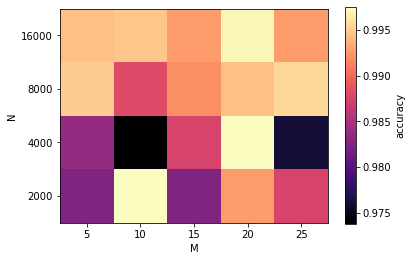

In [8]:
# region [2B]: INPUT SIZE N VS NUMBER OF HIDDEN NEURONS PER LAYER

# Dictionary of varying parameters
vals = {
    "N": 1000 * 2 ** np.arange(1, 5),
    # M is the number of neurons in each of the 2 Hidden Layers
    "M": np.arange(5, 26, 5),
}

# Dictionary of DNN configuration setups
params = [
    {
        "samples": samples,
        "input": {
            "N": N,
            "rescale": 50,
            "offset": 0,
            "train_frac": 0.8,
        },
        "model": {
            "name": "model",
            "layers": [
                tf.keras.layers.Dense(2, activation="elu"),
                tf.keras.layers.Dense(M, activation="elu"),
                tf.keras.layers.Dense(M, activation="elu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ],
        },
        "compile": {
            "loss": "binary_crossentropy",
            "optimizer": "adam",
            "metrics": ["accuracy"],
            "steps_per_execution": 4,
        },
        "fit": {"epochs": 500, "batch_size": 50, "verbose": 0},
    }
    for N, M in product(*vals.values())
]

fig, ax = gridplot(vals, [train(p)["val_accuracy"] for p in params])

2C) Hidden Layers vs Dropout percentage

We compare DNN architectures displaying different number of layers but a comparable number of parameters:

\begin{align*}
\text{neurons per layers} && \text{parameters} \\
(2,125,1)            && 507 \\
(2,20,20,1)          && 507\\
(2,16,16,10,1)       && 507\\
(2,11,12,12,12,1)    && 508\\
(2,11,10,10,10,10,1) && 500\\
\end{align*}
Correspondingly, we apply dropout rate $p$ to all the hidden layers of each model configuration. In particular, $$p\in \left\{0.0,0.1,0.2,0.3\right\}$$

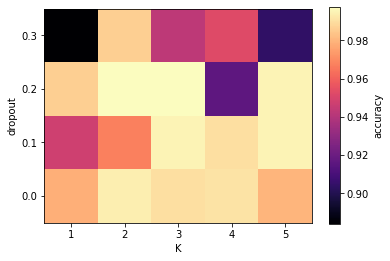

In [9]:
# region [2C]: # HIDDEN LAYERS VS DROPOUT PERCENTAGE
def gen_arch(neurons, p_drop):
    """
    This function generates the list of layers for the DNN model architecture starting from a list of neurons per layer and the dropout probabiblity per layer
    Args:
        neurons (list):
            list of neurons per layer
        p_drop (float):
            dropout fraction applied to each hidden layer of the architecture

    Returns:
        list:
            list of layers for the DNN architecture
    """
    layers = [tf.keras.layers.Dense(2, activation="elu")]
    for n in neurons:
        layers.append(tf.keras.layers.Dense(n, activation="elu"))
        layers.append(tf.keras.layers.Dropout(p_drop))
    layers.append(tf.keras.layers.Dense(1, activation="sigmoid"))
    return layers


# Dictionary of varying parameters used to plot the grid search:
vals = {
    "dropout": np.arange(4) / 10,
    "K": np.arange(1, 6),
}


# Dictionary of DNN configuration setups
params = [
    {
        "samples": samples,
        "input": {
            "N": 4000,
            "rescale": 50,
            "offset": 0,
            "train_frac": 0.8,
        },
        "model": {
            "name": "model",
            "layers": gen_arch(neurons, p_drop),
        },
        "compile": {
            "loss": "binary_crossentropy",
            "optimizer": "adam",
            "metrics": ["accuracy"],
            "steps_per_execution": 4,
        },
        "fit": {"epochs": 500, "batch_size": 50, "verbose": 0},
    }
    for p_drop in [0.0, 0.1, 0.2, 0.3]
    for neurons in [
        [125],
        [20, 20],
        [16, 16, 10],
        [11, 12, 12, 12],
        [11, 10, 10, 10, 10],
    ]
]

fig, ax = gridplot(vals, [train(p)["val_accuracy"] for p in params])